# Project
Rom Himelstein (325482768) and Yarden Adi (212585848)

## Part 1 - Data Selection, Visualization, and Introduction

### Dataset

The dataset originates from the Israel Central Bureau of Statistics (CBS) and encompasses the aggregate count of inbound and outbound passengers on flights to and from Israel. It spans from January 1989 to March 2022, constituting 399 entries and comprising two columns: one for dates and the other for the total number of passengers entering or departing from Israel (expressed in thousands).

Link to the dataset:
https://www.cbs.gov.il/en/Statistics/Pages/Generators/Time-Series-DataBank.aspx?level_1=17

### EDA

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from pmdarima import auto_arima
import copy
import logging
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import seaborn as sns


# Set logging level to ERROR
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

c:\Users\Rom\anaconda3\envs\TimeS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [90]:
df_flights = pd.read_csv('flights_325482768_212585848.csv')
df_flights.columns = ['Month', 'Passengers_Total_Original_Data_Thousands']
rng = pd.date_range(start='1989-01-01', end='2022-03-01', freq='MS')
df_flights.set_index(rng, inplace=True)
df_flights['Passengers_Total_Original_Data_Thousands'] = df_flights['Passengers_Total_Original_Data_Thousands'].str.replace(',', '')
df_flights['Passengers_Total_Original_Data_Thousands'] = df_flights['Passengers_Total_Original_Data_Thousands'].astype(float)
flights = df_flights['Passengers_Total_Original_Data_Thousands']

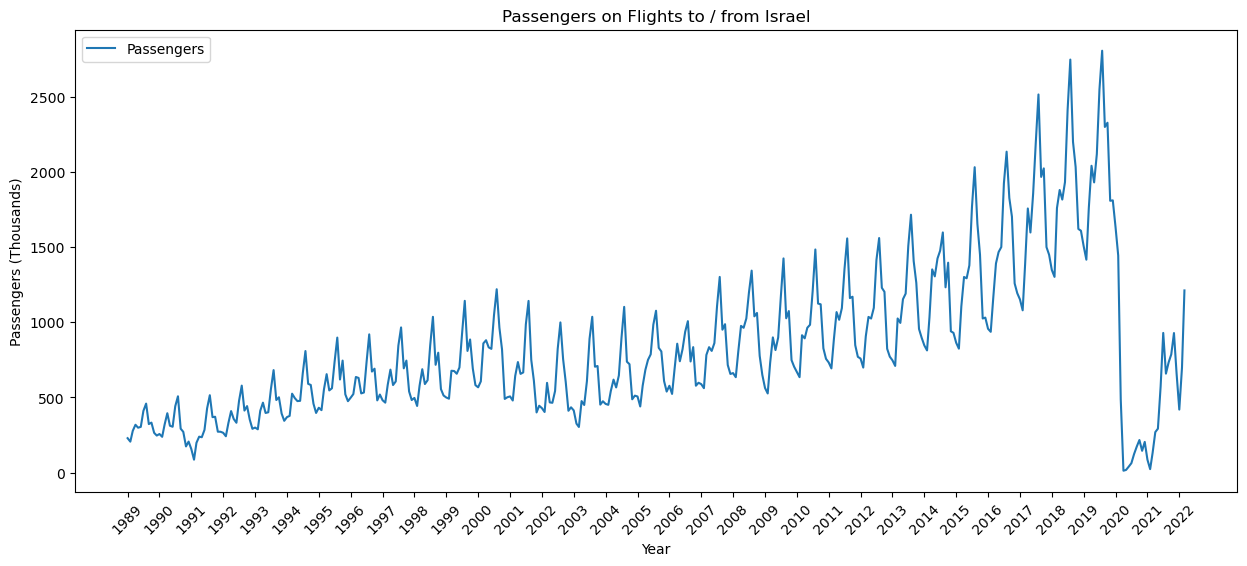

In [91]:
from matplotlib.dates import DateFormatter

plt.figure(figsize=(15, 6))
plt.plot(df_flights['Passengers_Total_Original_Data_Thousands'], label='Passengers')
plt.title('Passengers on Flights to / from Israel') 
plt.xticks(df_flights.index[::12], rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Format ticks to show only year
plt.xlabel('Year')
plt.ylabel('Passengers (Thousands)')
plt.legend()

In the depicted graph, there's a noticeable decline at the start of each year followed by a subsequent increase shortly after the midpoint of the year. This pattern suggests a seasonal trend with a period of $S = 12$ months, thus the series is not stationary.

Furthermore, between 1990 and 2000, there appears to be a gradual upward trend, followed by a minor decrease, then another upward trajectory until the notable decline in 2020 - coinciding with the impact of the COVID-19 pandemic.

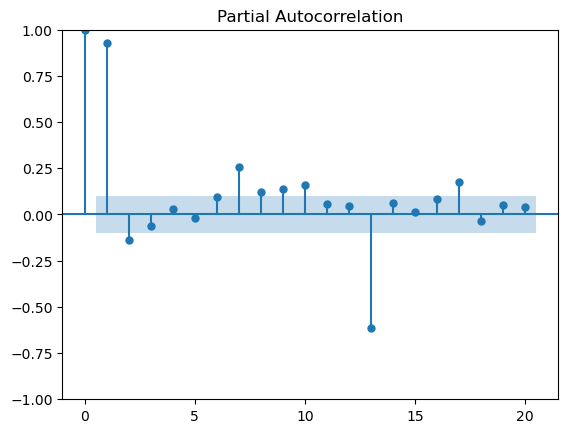

In [92]:
tsaplots.plot_pacf(flights, lags=20);

As evident from the Partial Autocorrelation Function (PACF) plot provided, a notable correlation is observed between $Y_t$ and $Y_{t-13}$. This finding appears somewhat unexpected, given our anticipation of a correlation between $Y_t$ and $Y_{t-12}$. However, this observation does confirm our hypothesis regarding the presence of significant seasonality within our dataset.

#### Differencing

Because of the first non-zero term in the PACF, let us try differencing with $d=1$, i.e., define $X_t = Y_t - Y_{t-1}$.

In [5]:
flights_one_diff = flights.diff(periods=1)
flights_one_diff.dropna(inplace=True)

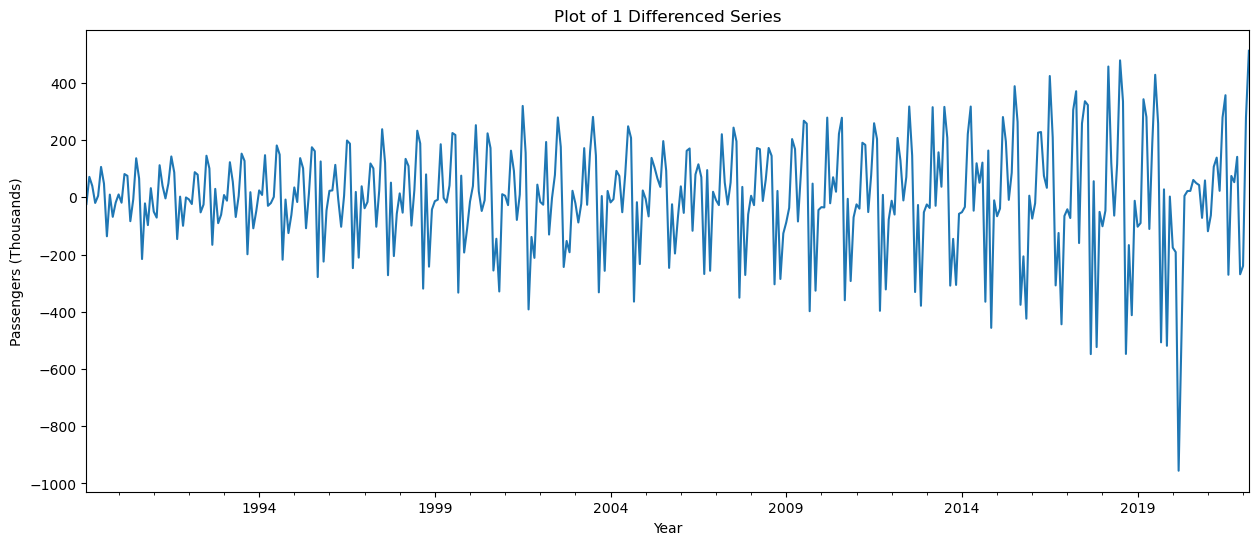

In [6]:
# plot series after differencing
flights_one_diff.plot(figsize=(15, 6))
plt.title("Plot of 1 Differenced Series")
plt.xlabel('Year')
plt.ylabel('Passengers (Thousands)')
plt.show()

As seen in the graph above, the upwards and downwards trend is almost non existant! Still, we can identify a seemingly yearly seasonal pattern in the data. Let us look at the PACF of the differenced series.

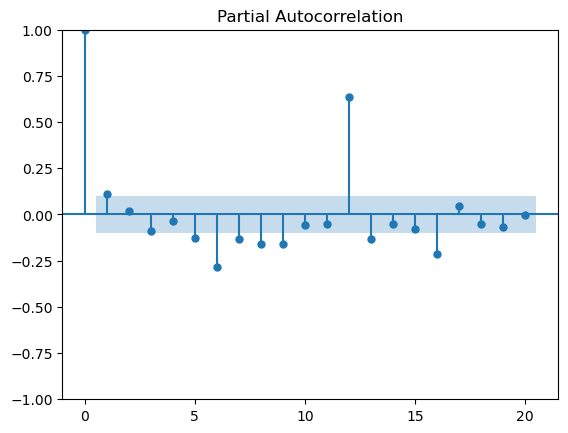

In [7]:
tsaplots.plot_pacf(flights_one_diff, lags=20);

As seen in the PACF graph above, only the 12th term is non-zero! This is the yearly seasonality we were expecting!

Now, let us difference again with $d=12$, i.e. define $Z_t = X_t - X_{t-12}$.

In [8]:
flights_another_year_diff = flights_one_diff.diff(periods=12)
flights_another_year_diff.dropna(inplace=True)

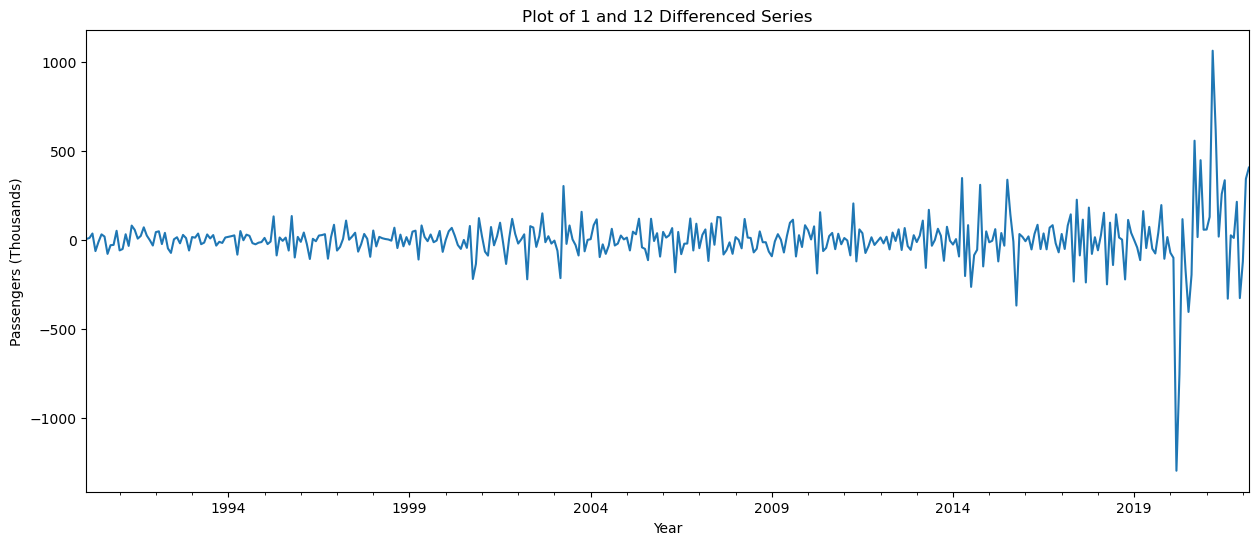

In [9]:
# plot series after differencing
flights_another_year_diff.plot(figsize=(15, 6))
plt.title("Plot of 1 and 12 Differenced Series")
plt.xlabel('Year')
plt.ylabel('Passengers (Thousands)')
plt.show()

In the displayed plot, the differenced series hovers around 0, indicating that we've effectively mitigated both the trend and seasonality present in the original series through simple differencing. To sum up, we have used two types of differencing, first with $d=1$ and then with $d=12$. The first differencing removed the trend, while the second differencing removed the seasonality.

Furthermore, the sudden dip observed in 2020 remains apparent, signifying an abrupt trend attributed to the pandemic.

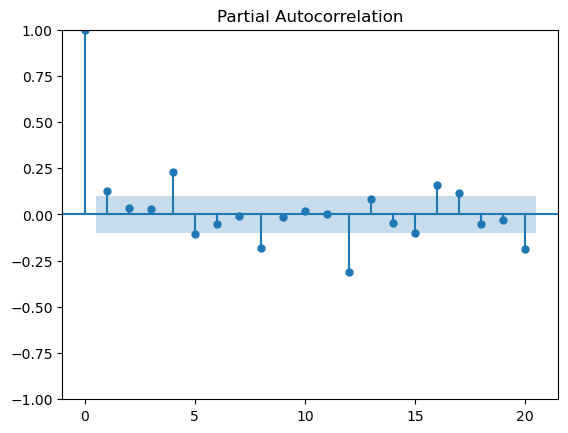

In [10]:
tsaplots.plot_pacf(flights_another_year_diff, lags=20);

As seen in the corrologram of the doubly differencing series, all of the PACFs are close to zero, in relation to their size in the previous series. This means we have essentially mitigated the dependency from the past!

## Part 2 - Model Fitting

In [11]:
# Define the default model data
def default_model_data():
    return {'predictions': [], 'RMSE': 0}
    
saved_models = defaultdict(default_model_data)

### Dividing to Train and Test

In [12]:
# Split the data into train and test sets, where the train set contains data points until 2014-12-01 and the test set contains data points from 2015-01-01 onwards
train = flights[:'2014-12-01']
test = flights['2015-01-01':]
TRAIN_SIZE = len(train)
TEST_SIZE = len(test)
print(f'Test set size: {TEST_SIZE}\nTrain set size: {TRAIN_SIZE}')

Test set size: 87
Train set size: 312


In [13]:
def plot_predictions(train, test, predictions, labels, title):
    plt.figure(figsize=(15, 6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    for prediction, label in zip(predictions, labels):
        plt.plot(prediction, label=label)
    plt.title('Predictions of Number of Passengers on Inbound and Outbound Flights in Israel\n' + f'({title})')
    plt.xticks(df_flights.index[::12], rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Format ticks to show only year
    plt.xlabel('Year')
    plt.ylabel('Passengers (Thousands)')
    plt.legend()
    plt.show()

In this part, we are going to fit our data using SARIMA, Prophet and a simple LSTM.

### $SARIMA$

As seen in the previous part, the doubly differenced series mitigates the trend and seasonality present in the original data. Therefore, we will fit a SARIMA model to the doubly differenced series (meaning $d=1$, $D=1$ and $S=12$).

Here, we use auto_arima to comb through different SAMRIMA parameters while minimizing the AIC. We fix $S=12,\ d=1$ and $D=1$.

In [14]:
automatic_sarima_model = auto_arima(train, seasonal=True, m=12, D=1, d=1, start_p=0, max_p=4,
                            start_q=0, max_q=4, start_P=0, max_P=4, start_Q=0, max_Q=4,
                            error_action='warn', trace=True,
                            suppress_warnings=True,
                            random_state=42, n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3433.034, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3323.847, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3302.429, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3383.335, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3303.296, Time=0.54 sec


 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3303.484, Time=1.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3320.036, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3305.291, Time=1.23 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3321.391, Time=0.18 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3289.078, Time=0.60 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3381.816, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3290.046, Time=0.63 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3290.131, Time=1.82 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3314.177, Time=0.43 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=3292.046, Time=2.98 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=3305.796, Time=0.31 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=3290.155, Time=1.63 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=3290.503, Time=1.66 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=3299.761, Time=0.48 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=3307.391, Time=0.45

Now computing $SARIMA(1,1,1)(0,1,1)_{S=12}$

In [15]:
flights_model_3 = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
flights_model_3_fit = flights_model_3.fit(disp=False)
flights_model_3_pred = flights_model_3_fit.get_forecast(steps=TEST_SIZE)
print(flights_model_3_fit.summary())

                                          SARIMAX Results                                           
Dep. Variable:     Passengers_Total_Original_Data_Thousands   No. Observations:                  312
Model:                       SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1640.539
Date:                                      Sat, 04 May 2024   AIC                           3289.078
Time:                                              15:54:15   BIC                           3303.880
Sample:                                          01-01-1989   HQIC                          3295.003
                                               - 12-01-2014                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5422      0.071  

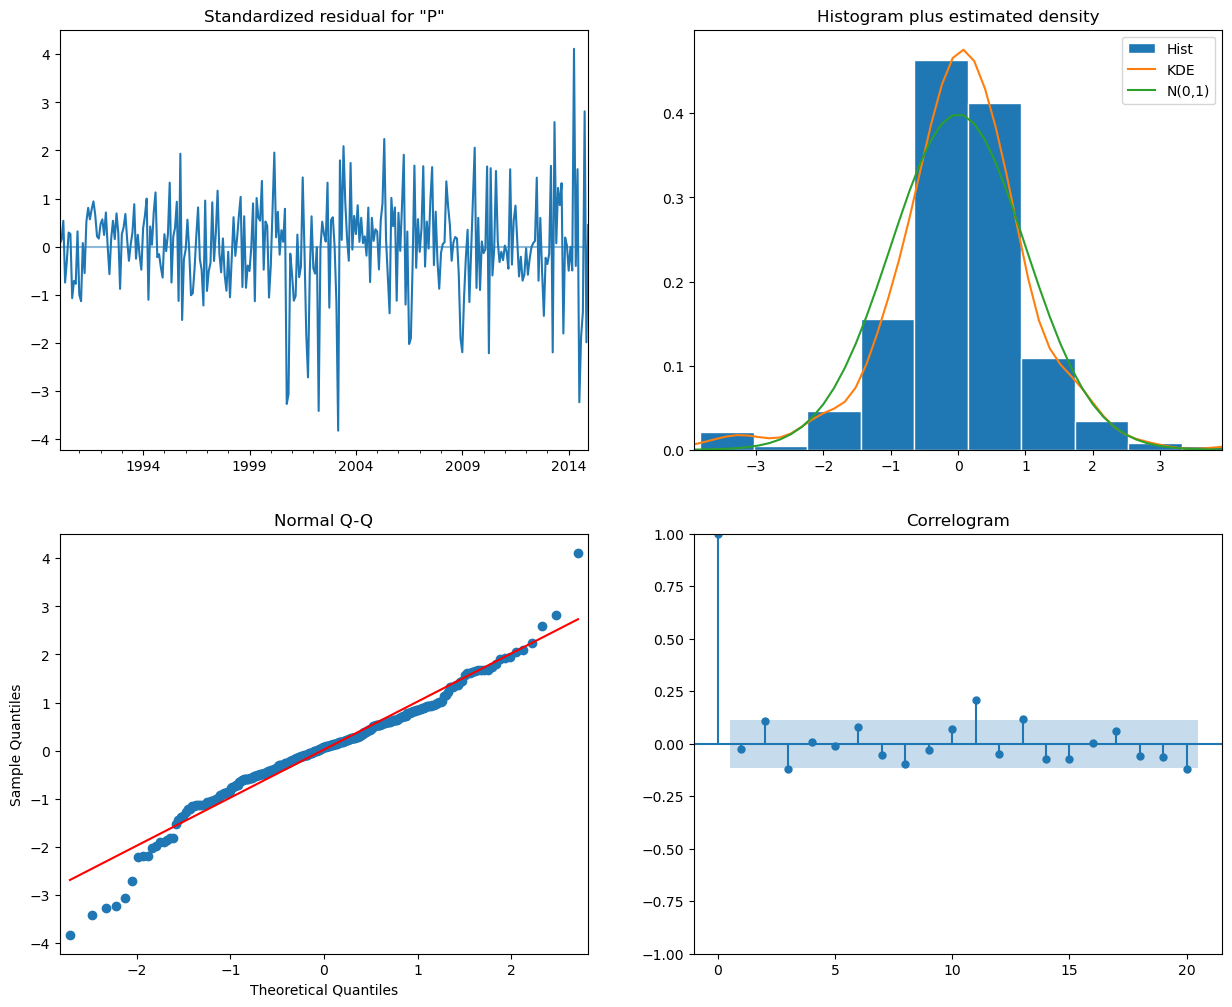

In [16]:
flights_model_3_fit.plot_diagnostics(figsize=(15, 12), lags=20);

As seen in the graphs above, the model's residuals are around the line $e=0$ with similar spreads around the line, and the normal Q-Q plot conforms with a normal distribution. Additionally, as seen in the corrologram, the values are close to zero, meaning the seasonality has been neutralized. For those reasons, the model we chose fits the data well.

As seen above, the auto_arima module chose $SARIMA(1,1,1)(0,1,1)_{S=12}$ which includes our fixed parameters and additional components. The AIC value is $3289.078$.

#### Plotting $SARIMA$ Model

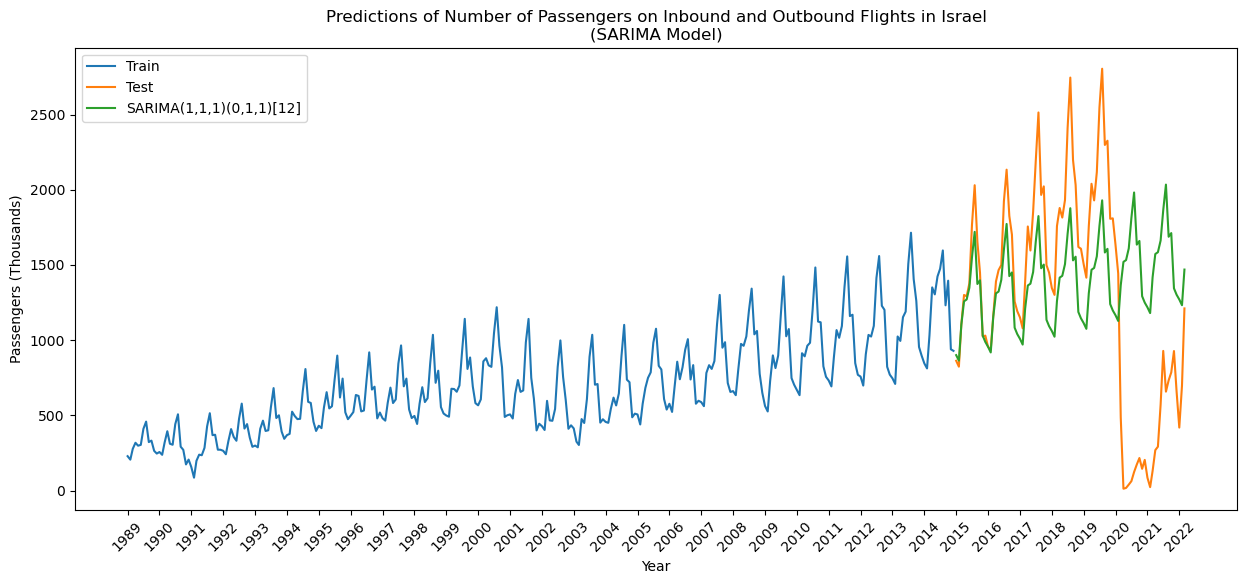

In [17]:
# plotting the predictions
plot_predictions(train, test, [flights_model_3_pred.predicted_mean], ['SARIMA(1,1,1)(0,1,1)[12]'], title='SARIMA Model')

The above graph presents the chosen $SARIMA$ model's results in predicting the number of passengers on inbound and outbound flights in Israel.

#### One-Month-Ahead (OMA) Strategy
As evident from the analysis, the $SARIMA$ model fails to capture the sudden trend decline after 2020 due to the COVID-19 pandemic. Consequently, we've opted to alter our forecasting approach. Rather than projecting distant data points, we now focus solely on predicting the upcoming month. Additionally, we employ a "forced teaching" strategy, ensuring that the model always receives actual data points preceding the predicted month. We will name this forecasting strategy **one-month-ahead (OMA)**.

#### Using Root Mean Squared Error (RMSE)
We will be using the RMSE criterion to compare all the following models, as we will not be able to use $AIC$ or $BIC$. 

This is due to a couple of reasons: 
1. In OMA we train a new model every time we predict a point, so $AIC$ and $BIC$ are not the right criteria.
2. Prophet and LSTM do not support the calculation of the $AIC$ and $BIC$ criteria.

In [18]:
def calc_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

In [19]:
sarima_models = [copy.deepcopy(flights_model_3_fit)] # was multiple models but we removed them in the end :)
sarima_predictions = []

for i, sm in enumerate(sarima_models):
    print(f'starting model {i}')
    sm_pred = pd.Series([])
    for test_index, test_point in test.items():
        forecast = sm.forecast(steps=1)
        sm_pred.at[test_index] = forecast.iloc[0]
        # sm_pred.add(sm.forecast(steps=1))
        # Append the new data point with the correct index frequency
        new_data_point = pd.Series(test_point, index=[test_index], name=sm.model.endog_names)
        sm = sm.append(new_data_point, refit=True)
    sarima_predictions.append(sm_pred)

starting model 0


We sometimes use relu on our predictions, as predictions of negative values are not valid in our context.

In [20]:
def relu(series):
    return pd.Series(np.maximum(series, 0), index=series.index)

In [21]:
sarima_relu_predictions = [relu(pred) for pred in sarima_predictions]
sarima_rmses = [calc_rmse(test, pred) for pred in sarima_relu_predictions]

#### OMA vs. Without

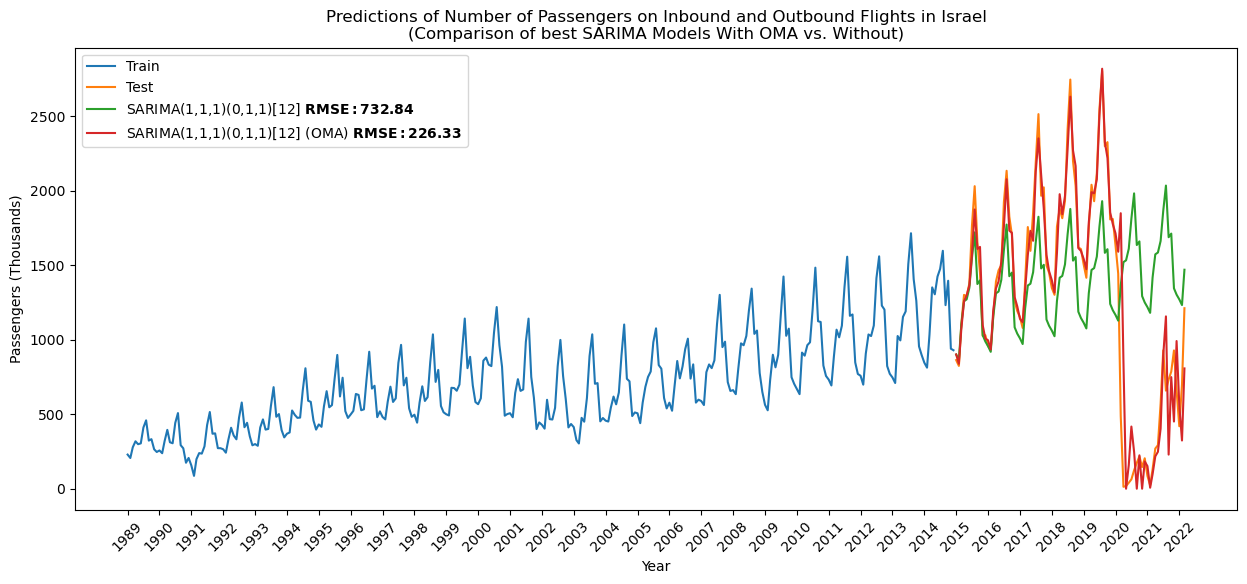

In [22]:
model_3_rmse = calc_rmse(test, flights_model_3_pred.predicted_mean)

saved_models['SARIMA(1,1,1)(0,1,1)[12]']['predictions'] = flights_model_3_pred.predicted_mean
saved_models['SARIMA(1,1,1)(0,1,1)[12]']['RMSE'] = model_3_rmse

saved_models['SARIMA(1,1,1)(0,1,1)[12] (OMA)']['predictions'] = sarima_relu_predictions[0]
saved_models['SARIMA(1,1,1)(0,1,1)[12] (OMA)']['RMSE'] = sarima_rmses[0]

plot_predictions(train, test, [flights_model_3_pred.predicted_mean, sarima_relu_predictions[0]],\
     [f'SARIMA(1,1,1)(0,1,1)[12] $\\mathbf{{RMSE: {model_3_rmse:.2f}}}$', f'SARIMA(1,1,1)(0,1,1)[12] (OMA) $\\mathbf{{RMSE: {sarima_rmses[0]:.2f}}}$'],\
      'Comparison of best SARIMA Models With OMA vs. Without')

The above graph presents the comparison of the best $SARIMA$ model with OMA and without OMA in predicting the number of passengers on inbound and outbound flights in Israel.

As evident from the RMSEs and the predictions on the graphs, the OMA approach is superior to the regular one. This is not surprising, since the OMA approach adjusts the model before predicting each data point according to its entire past.

### Prophet

#### Prophet without Yearly Seasonality

In [23]:
flights_model_4 = Prophet(yearly_seasonality=False)
flights_model_4.fit(train.reset_index().rename(columns={'index': 'ds', 'Passengers_Total_Original_Data_Thousands': 'y'}));

15:54:58 - cmdstanpy - INFO - Chain [1] start processing
15:54:58 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future_dates = flights_model_4.make_future_dataframe(periods=TEST_SIZE, freq='MS', include_history=False)
forecast = flights_model_4.predict(future_dates)
flights_model_4_df = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')
flights_model_4_df['yhat'] = (flights_model_4_df['yhat_lower'] + flights_model_4_df['yhat_upper']) / 2

#### Prophet with Yearly Seasonality

In [25]:
flights_model_5 = Prophet(yearly_seasonality=True)
flights_model_5.fit(train.reset_index().rename(columns={'index': 'ds', 'Passengers_Total_Original_Data_Thousands': 'y'}));

15:54:59 - cmdstanpy - INFO - Chain [1] start processing
15:54:59 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
future_dates = flights_model_5.make_future_dataframe(periods=TEST_SIZE, freq='MS', include_history=False)
forecast = flights_model_5.predict(future_dates)
flights_model_5_df = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')
flights_model_5_df['yhat'] = (flights_model_5_df['yhat_lower'] + flights_model_5_df['yhat_upper']) / 2

We will plot the components of the model to see the effect of the yearly seasonality.

c:\Users\Rom\anaconda3\envs\TimeS\Lib\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Rom\anaconda3\envs\TimeS\Lib\site-packages\prophet\plot.py:349: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Rom\anaconda3\envs\TimeS\Lib\site-packages\prophet\plot.py:352: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain

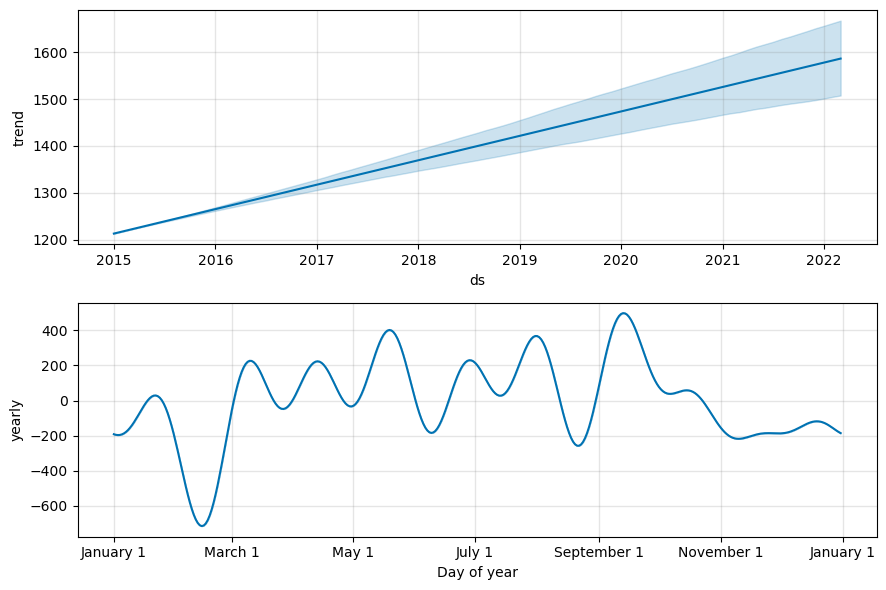

In [27]:
# plot prophet seasonality and trend graphs
flights_model_5.plot_components(forecast);

As observed above, there's a consistent upward trend in flights from 2015 to 2022, as illustrated in the original data graph. Notably, the trend here is strictly ascending, while in the initial dataset, it showed an increase followed by a decrease. This discrepancy arises because the model couldn't anticipate the decline in flights in 2020 due to the COVID-19 pandemic. Additionally, the seasonal pattern graph indicates fewer passengers at the beginning of the year, with the highest numbers occurring in September and October. This is surprising since we initially assumed July and August would see the highest passenger volume, given that it's summertime and many families choose this period for vacations abroad.

#### Comparison between Prophet Models

In [28]:
model_4_predictions = flights_model_4_df['yhat']
model_5_predictions = flights_model_5_df['yhat']

model_4_rmse = calc_rmse(test, model_4_predictions)
model_5_rmse = calc_rmse(test, model_5_predictions)

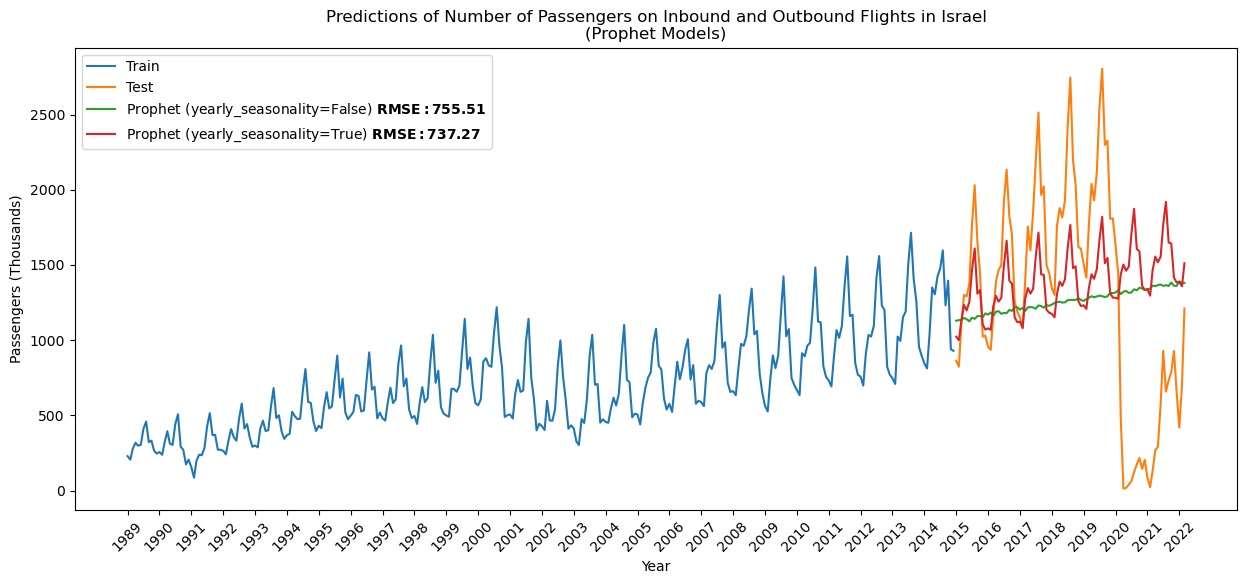

In [29]:
plot_predictions(train, test, [model_4_predictions, model_5_predictions], 
                 [f"Prophet (yearly_seasonality=False) $\\mathbf{{RMSE: {model_4_rmse:.2f}}}$", 
                  f"Prophet (yearly_seasonality=True) $\\mathbf{{RMSE: {model_5_rmse:.2f}}}$"], 
                 title='Prophet Models')

The above graph presents the comparison of Prophet models with yearly seasonality and without in predicting the number of passengers on inbound and outbound flights in Israel.

As can be clearly seen above, Prophet with yearly seasonality is superior in predicting our time series. This is consistent with our conclusion from part 1, which claimed there was seasonality with $S=12$.  

Additionally, now we employ the OMA strategy of predicting, and see how it improves on the current way of predicting.

In [30]:
# employing the one-month-ahead strategy in Prophet with yearly seasonality
running_training_set = copy.deepcopy(train)
prophet_predictions = pd.Series([])

for i, (test_index, test_point) in enumerate(test.items()):
    # Fit Prophet model
    model = Prophet(yearly_seasonality=True)
    model.fit(running_training_set.reset_index().rename(columns={'index': 'ds', 'Passengers_Total_Original_Data_Thousands': 'y'}))
    
    # Make one-month-ahead forecast
    future_dates = model.make_future_dataframe(periods=1, freq='MS', include_history=False)
    forecast = model.predict(future_dates)
    
    # Store the prediction
    prophet_predictions.at[test_index] = forecast['yhat'].iloc[0]
    
    # Update the running training set
    running_training_set.at[test_index] = test_point

15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:00 - cmdstanpy - INFO - Chain [1] done processing
15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:00 - cmdstanpy - INFO - Chain [1] done processing


15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:01 - cmdstanpy - INFO - Chain [1] done processing
15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:01 - cmdstanpy - INFO - Chain [1] done processing
15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:01 - cmdstanpy - INFO - Chain [1] done processing
15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:01 - cmdstanpy - INFO - Chain [1] done processing
15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:01 - cmdstanpy - INFO - Chain [1] done processing
15:55:02 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing
15:55:02 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing
15:55:02 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing
15:55:02 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1]

In [31]:
model_5_with_one_month_ahead_rmse = calc_rmse(test, prophet_predictions)

#### OMA vs. Without

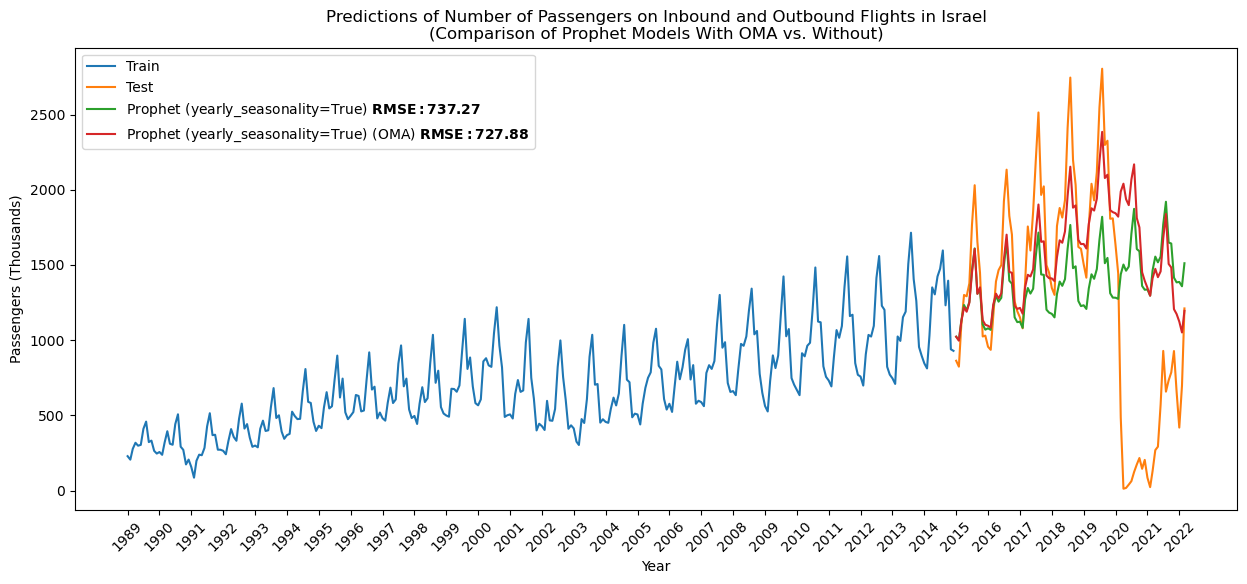

In [32]:
saved_models['Prophet']['predictions'] = model_5_predictions
saved_models['Prophet']['RMSE'] = model_5_rmse

saved_models['Prophet (OMA)']['predictions'] = prophet_predictions
saved_models['Prophet (OMA)']['RMSE'] = model_5_with_one_month_ahead_rmse

plot_predictions(train, test, [model_5_predictions, prophet_predictions],
                    [f"Prophet (yearly_seasonality=True) $\\mathbf{{RMSE: {model_5_rmse:.2f}}}$",
                     f"Prophet (yearly_seasonality=True) (OMA) $\\mathbf{{RMSE: {model_5_with_one_month_ahead_rmse:.2f}}}$"],
                    title='Comparison of Prophet Models With OMA vs. Without')

The above graph presents the comparison of the Prophet model with OMA and without in predicting the number of passengers on inbound and outbound flights in Israel.

As displayed in the graph above, the OMA strategy outperforms the one without. However, the difference between the predictions of both strategies are not substantial (as was in the SARIMA models). Prophet has a hard time in identifying the sudden drop in flights in 2020.

### LSTM

LSTMs typically train on datasets consisting of short time series. Since we only possess one time series, we've opted to utilize the common window approach. This technique involves training the LSTM on a dataset composed of windows extracted from the time series. Consequently, we can transform our solitary time series into multiple ones, enhancing our training dataset.

In [33]:
# Length of sequences
seq_length = 12

# Prepare the training data
X_train = np.array(train)
X_test = np.concatenate((X_train[-seq_length:], np.array(test))) # in order to predict the first seq_length values in the test set

In [34]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(X_train.reshape(-1, 1))
scaled_test_data = scaler.transform(X_test.reshape(-1, 1))


# Define function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


# Create sequences
X_train, y_train = create_sequences(scaled_train_data, seq_length)
X_test, y_test = create_sequences(scaled_test_data, seq_length)

In [35]:
def create_lstm_model(seq_length, input_dim):
    model = Sequential()
    model.add(Input(shape=(seq_length, input_dim)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [36]:
model = create_lstm_model(seq_length, 1)
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

Generate test data using only the training data (without forced teaching).

In [37]:
# use the LSTM model to generate predictions of the test data (generative approach)
running_test_data = copy.deepcopy(scaled_train_data[-seq_length:])

predicted_values = []
for i in range(len(test)):
    # Reshape the data to be 3D
    X = running_test_data.reshape(1, seq_length, 1)
    # Make a prediction
    prediction = model.predict(X, verbose=0)
    predicted_values.append(prediction[0][0])
    # Update the running test data with our prediction
    running_test_data = np.append(running_test_data, prediction)
    running_test_data = running_test_data[1:] # remove the first element

In [38]:
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

In [39]:
lstm_predictions = pd.Series([])

for i, (test_index, test_point) in enumerate(test.items()):
    lstm_predictions.at[test_index] = predicted_values[i][0]

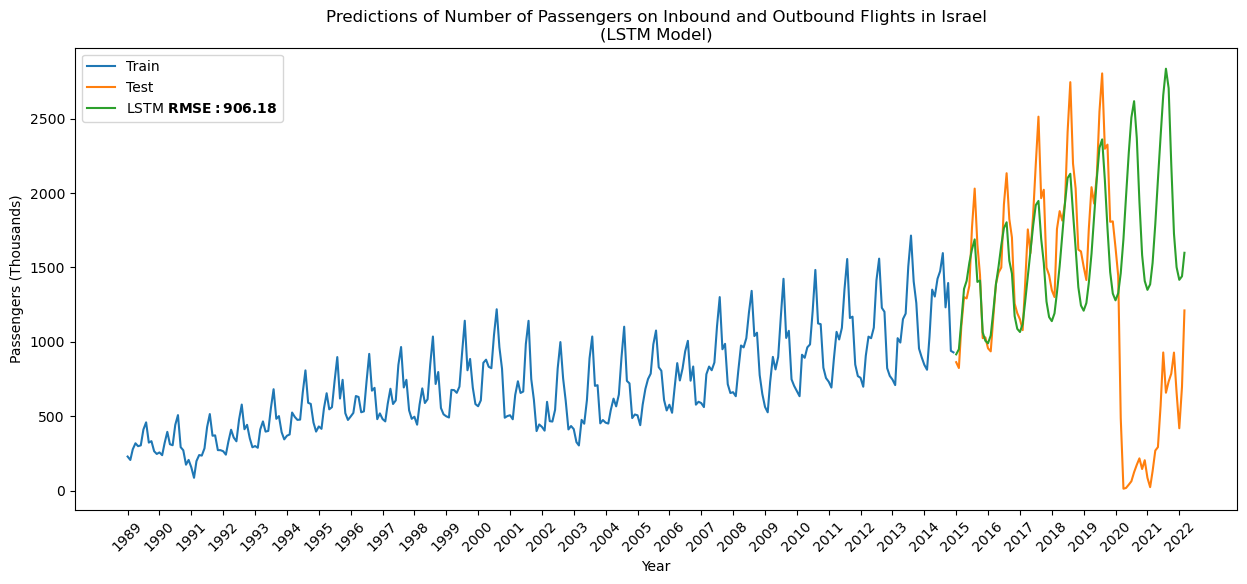

In [40]:
lste_relu_predictions = relu(lstm_predictions)
lstm_rmse = calc_rmse(test, lste_relu_predictions)
plot_predictions(train, test, [lste_relu_predictions],
                    [f"LSTM $\\mathbf{{RMSE: {lstm_rmse:.2f}}}$"],
                    title='LSTM Model')

The above graph presents the LSTM's predictions of the number of passengers on inbound and outbound flights in Israel.

#### OMA

In [41]:
model = create_lstm_model(seq_length, 1)

In [42]:
# one-month-ahead lstm
running_X_train = copy.deepcopy(X_train)
running_y_train = copy.deepcopy(y_train)
running_predictions = []

for test_window, test_point in zip(X_test, y_test):
    model.fit(running_X_train, running_y_train, epochs=100, batch_size=32, verbose=0)
    prediction = model.predict(test_window.reshape(1, seq_length, 1), verbose=0)
    # Update the running training set with the new (real) data point (forced teaching)
    running_X_train = np.concatenate((running_X_train, test_window.reshape(1, seq_length, 1)))
    running_y_train = np.concatenate((running_y_train, test_point.reshape(1, 1)))
    running_predictions.append(scaler.inverse_transform(prediction)[0][0])
    

In [43]:
lstm_OMA_predictions = pd.Series([])

for i, (test_index, test_point) in enumerate(test.items()):
    lstm_OMA_predictions.at[test_index] = running_predictions[i]

In [44]:
lstm_OMA_relu_predictions = relu(lstm_OMA_predictions)

#### OMA vs. Without

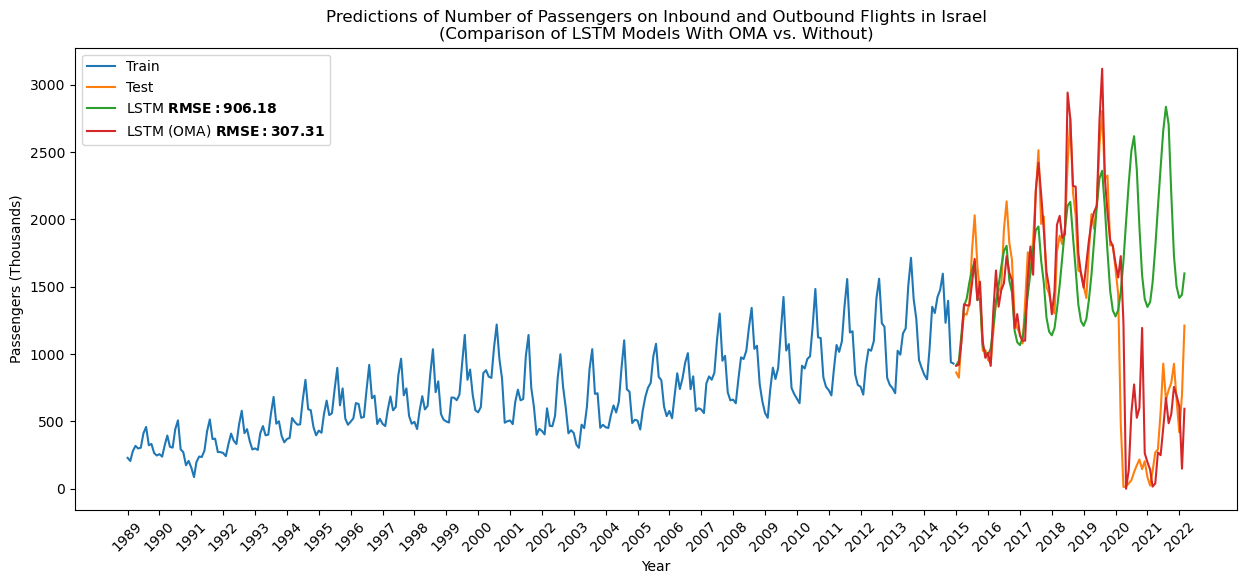

In [45]:
lstm_OMA_rmse = calc_rmse(test, lstm_OMA_relu_predictions)
# plot regular LSTM model vs. One-Month-Ahead LSTM model

saved_models['LSTM']['predictions'] = lste_relu_predictions
saved_models['LSTM']['RMSE'] = lstm_rmse

saved_models['LSTM (OMA)']['predictions'] = lstm_OMA_relu_predictions
saved_models['LSTM (OMA)']['RMSE'] = lstm_OMA_rmse

plot_predictions(train, test, [lste_relu_predictions, lstm_OMA_relu_predictions],
                    [f"LSTM $\\mathbf{{RMSE: {lstm_rmse:.2f}}}$",
                     f"LSTM (OMA) $\\mathbf{{RMSE: {lstm_OMA_rmse:.2f}}}$"],
                    title='Comparison of LSTM Models With OMA vs. Without')

The above graph presents the comparison of the LSTM model with OMA and without in predicting the number of passengers on inbound and outbound flights in Israel.

As displayed in the graph above, the OMA strategy outperforms the one without by a significant margin.

### Comparing all Models Predictions

#### Without OMA Strategy

In [46]:
# Extract predictions and labels for regular models without "OMA" in their keys
regular_models_predictions = [value['predictions'] for key, value in saved_models.items() if 'OMA' not in key]
regular_models_labels = [f"{key} $\\mathbf{{RMSE: {value['RMSE']:.2f}}}$" for key, value in saved_models.items() if 'OMA' not in key]

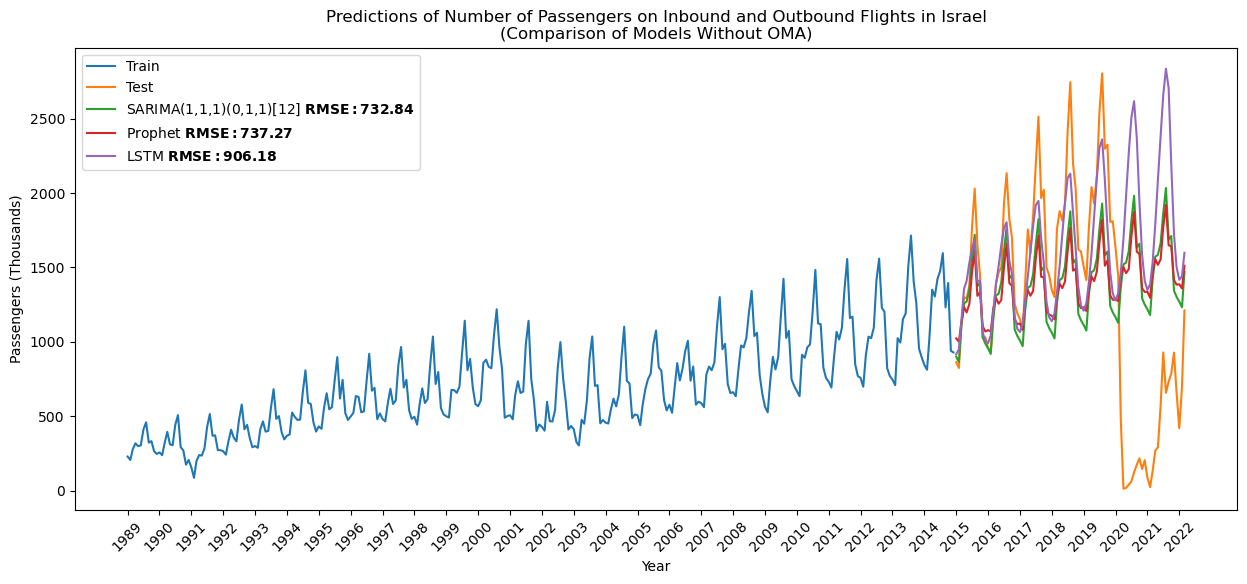

In [47]:
plot_predictions(train, test, regular_models_predictions, regular_models_labels, 'Comparison of Models Without OMA')

The above graph presents the comparison different models in predicting the number of passengers on inbound and outbound flights in Israel.

The SARIMA model is the best performing, followed by Prophet and LSTM far behind.

#### With OMA Strategy

In [48]:
# Extract predictions and labels for regular models without "OMA" in their keys
oma_models_predictions = [value['predictions'] for key, value in saved_models.items() \
                          if 'OMA' in key and 'EXOG' not in key]
oma_models_labels = [f"{key} $\\mathbf{{RMSE: {value['RMSE']:.2f}}}$" for key, value in saved_models.items() \
                     if 'OMA' in key and 'EXOG' not in key]

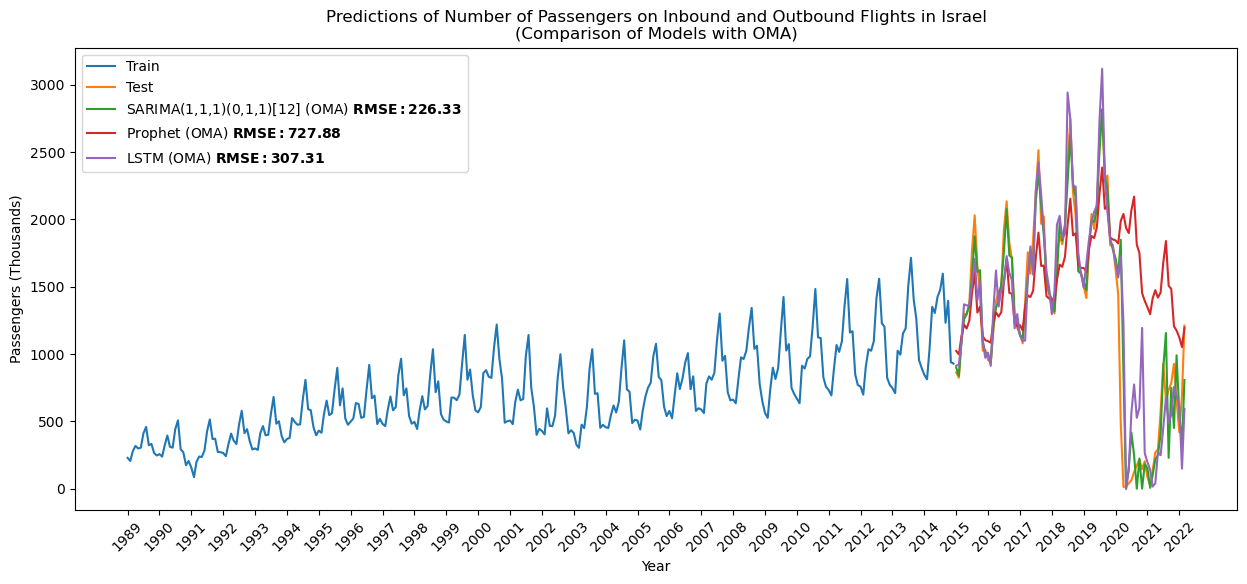

In [49]:
plot_predictions(train, test, oma_models_predictions, oma_models_labels, 'Comparison of Models with OMA')

The above graph presents the comparison different OMA models in predicting the number of passengers on inbound and outbound flights in Israel.

Unexpectedly, the $SARIMA$ model outperformed the others again, with the LSTM model close behind.

## Part 3 - Incorporating an Exogenous Variable

In this part, we will integrate an external variable into our models. We've opted for the ILS to USD exchange rate as our external variable, considering it a reliable indicator of socio-economic conditions in Israel, potentially influencing flight passenger numbers. Since we require monthly exchange rate data, we'll utilize the average exchange rate per month. Our dataset spans from January 1989 to March 2022.

### EDA

In [93]:
exr = pd.read_csv('EXR_325482768_212585848.csv')
exr = exr[['TIME_PERIOD', 'OBS_VALUE']]
exr = exr.rename(columns={'TIME_PERIOD': 'Month', 'OBS_VALUE': 'Exchange Rate'})
exr['Month'] = pd.to_datetime(exr['Month'])

start_date = pd.to_datetime('1989-01-01')
end_date = pd.to_datetime('2022-03-31')

# Filter the DataFrame based on the 'Month' column
filtered_exr = exr[(exr['Month'] >= start_date) & (exr['Month'] <= end_date)]
filtered_exr.set_index('Month', inplace=True)

monthly_average_exchange_rate = filtered_exr.resample('M')['Exchange Rate'].mean()

# replace each row in the Month column to be the first day of the month
monthly_average_exchange_rate.index = monthly_average_exchange_rate.index.to_period('M').to_timestamp()

In [51]:
# # save combined dataset
# combined_dataset = pd.concat([flights, monthly_average_exchange_rate], axis=1)
# combined_dataset.to_csv("flights_and_exr.csv")

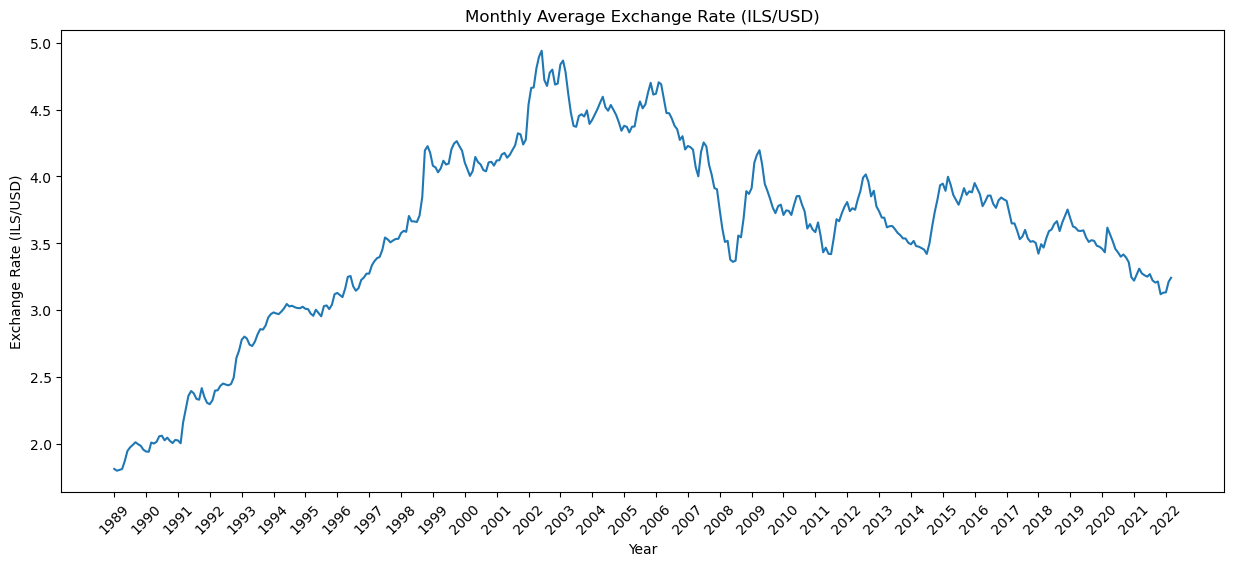

In [94]:
# Plot the monthly average exchange rate
plt.figure(figsize=(15, 6))
plt.plot(monthly_average_exchange_rate)
plt.title('Monthly Average Exchange Rate (ILS/USD)')
plt.xticks(monthly_average_exchange_rate.index[::12], rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Format ticks to show only year
plt.xlabel('Year')
plt.ylabel('Exchange Rate (ILS/USD)')
plt.show()

The above graph presents the ILS to USD monthly average exchange rate from January 1989 to March 2022.

### $SARIMA$

In [53]:
train_exr = monthly_average_exchange_rate[:'2014-12-01']
test_exr = monthly_average_exchange_rate['2015-01-01':]
TRAIN_SIZE_EXR = len(train_exr)
TEST_SIZE_EXR = len(test_exr)

print(f'Test set size: {TEST_SIZE_EXR}\nTrain set size: {TRAIN_SIZE_EXR}')

Test set size: 87
Train set size: 312


In [54]:
# auto SARIMA with exogenous variable (with fixed parameters just like before)
sarima_exog_model = auto_arima(train, exogenous=train_exr, seasonal=True, m=12, D=1, d=1, start_p=0, max_p=4,
                            start_q=0, max_q=4, start_P=0, max_P=4, start_Q=0, max_Q=4,
                            error_action='warn', trace=True,
                            suppress_warnings=True,
                            random_state=42, n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3433.034, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3323.847, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3302.429, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3383.335, Time=0.15 sec


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3303.296, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3303.484, Time=0.89 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3320.036, Time=0.23 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3305.291, Time=1.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3321.391, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3289.078, Time=0.55 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3381.816, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3290.046, Time=0.63 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3290.131, Time=1.79 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3314.177, Time=0.41 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=3292.046, Time=2.78 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=3305.796, Time=0.42 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=3290.155, Time=1.30 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=3290.503, Time=1.27 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=3299.761, Time=0.46

Picked the same model as before, $SARIMA(1,1,1)(0,1,1)_{S=12}$.

In [55]:
sarima_exog_oma = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), exog=train_exr)
sarima_exog_oma_fit = sarima_exog_oma.fit(disp=False)

sarima_exog_oma_predictions = pd.Series([])
for (test_index, test_point), test_point_exr in zip(test.items(), test_exr):
    # Append the new data point with the correct index frequency
    new_data_point = pd.Series(test_point, index=[test_index], name=sarima_exog_oma_fit.model.endog_names)
    new_exog_data_point = pd.Series(test_point_exr, index=[test_index], name=sarima_exog_oma_fit.model.exog_names[0])

    forecast = sarima_exog_oma_fit.forecast(steps=1, exog=new_exog_data_point)
    sarima_exog_oma_predictions.at[test_index] = forecast.iloc[0]

    sarima_exog_oma_fit = sarima_exog_oma_fit.append(new_data_point, exog=new_exog_data_point, refit=True)

c:\Users\Rom\anaconda3\envs\TimeS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Rom\anaconda3\envs\TimeS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Plot OMA $SARIMA$ With Exogenous Variable vs. Without

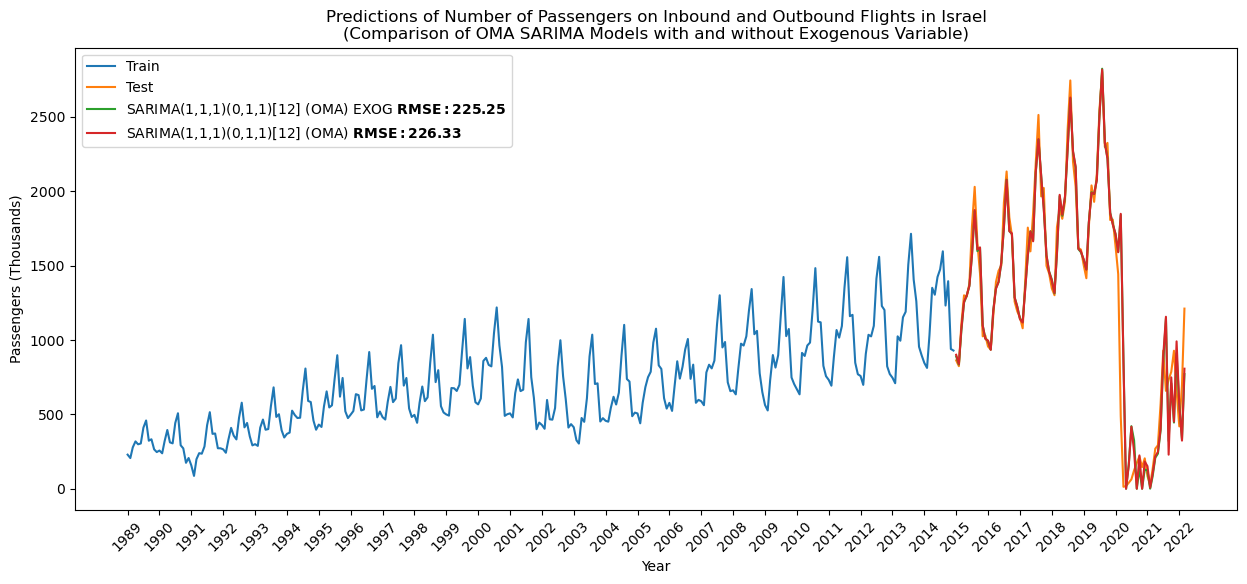

In [56]:
sarima_exog_oma_relu_predictions = relu(sarima_exog_oma_predictions)
sarima_exog_oma_rmse = calc_rmse(test, sarima_exog_oma_relu_predictions)

saved_models['SARIMA(1,1,1)(0,1,1)[12] (OMA) EXOG']['predictions'] = sarima_exog_oma_relu_predictions
saved_models['SARIMA(1,1,1)(0,1,1)[12] (OMA) EXOG']['RMSE'] = sarima_exog_oma_rmse


# plot OMA SARIMA with exogenous variable vs without
plot_predictions(train, test, [sarima_exog_oma_relu_predictions, sarima_relu_predictions[0]],
                    [f'SARIMA(1,1,1)(0,1,1)[12] (OMA) EXOG $\\mathbf{{RMSE: {sarima_exog_oma_rmse:.2f}}}$',
                     f'SARIMA(1,1,1)(0,1,1)[12] (OMA) $\\mathbf{{RMSE: {sarima_rmses[0]:.2f}}}$'],
                    'Comparison of OMA SARIMA Models with and without Exogenous Variable')

The above graph presents the comparison of the OMA $SARIMA$ model with and without the exogenous variable in predicting the number of passengers on inbound and outbound flights.

The model with the exogenous variable outperforms the one without by a very small margin. This is surprising as we thought it would assist the model's predictions.

### Prophet

As we saw yearly seasonality is superior, we will use it.

In [57]:
train_exog = pd.concat([train, train_exr], axis=1)
test_exog = pd.concat([test, test_exr], axis=1)

In [58]:
# OMA Prophet with exogenous variable
running_training_set_exog = copy.deepcopy(train_exog)
prophet_exog_predictions = pd.Series([])

for i, (test_index, test_point) in enumerate(test_exog.iterrows()):
    # Fit Prophet model
    model = Prophet(yearly_seasonality=True)
    model.add_regressor('Exchange Rate')
    model.fit(running_training_set_exog.reset_index().rename(columns={'index': 'ds', 'Passengers_Total_Original_Data_Thousands': 'y'}))
    
    # Make one-month-ahead forecast
    future_dates = model.make_future_dataframe(periods=1, freq='MS', include_history=False)
    future_dates['Exchange Rate'] = test_point['Exchange Rate']
    forecast = model.predict(future_dates)
    
    # Store the prediction
    prophet_exog_predictions.at[test_index] = forecast['yhat'].iloc[0]
    
    # Update the running training set
    running_training_set_exog.loc[test_index] = test_point


16:08:23 - cmdstanpy - INFO - Chain [1] start processing
16:08:23 - cmdstanpy - INFO - Chain [1] done processing
16:08:23 - cmdstanpy - INFO - Chain [1] start processing


16:08:23 - cmdstanpy - INFO - Chain [1] done processing
16:08:23 - cmdstanpy - INFO - Chain [1] start processing
16:08:23 - cmdstanpy - INFO - Chain [1] done processing
16:08:24 - cmdstanpy - INFO - Chain [1] start processing
16:08:24 - cmdstanpy - INFO - Chain [1] done processing
16:08:24 - cmdstanpy - INFO - Chain [1] start processing
16:08:24 - cmdstanpy - INFO - Chain [1] done processing
16:08:24 - cmdstanpy - INFO - Chain [1] start processing
16:08:24 - cmdstanpy - INFO - Chain [1] done processing
16:08:24 - cmdstanpy - INFO - Chain [1] start processing
16:08:24 - cmdstanpy - INFO - Chain [1] done processing
16:08:24 - cmdstanpy - INFO - Chain [1] start processing
16:08:24 - cmdstanpy - INFO - Chain [1] done processing
16:08:25 - cmdstanpy - INFO - Chain [1] start processing
16:08:25 - cmdstanpy - INFO - Chain [1] done processing
16:08:25 - cmdstanpy - INFO - Chain [1] start processing
16:08:25 - cmdstanpy - INFO - Chain [1] done processing
16:08:25 - cmdstanpy - INFO - Chain [1] 

#### Plot OMA Prophet With Exogenous Variable vs. Without

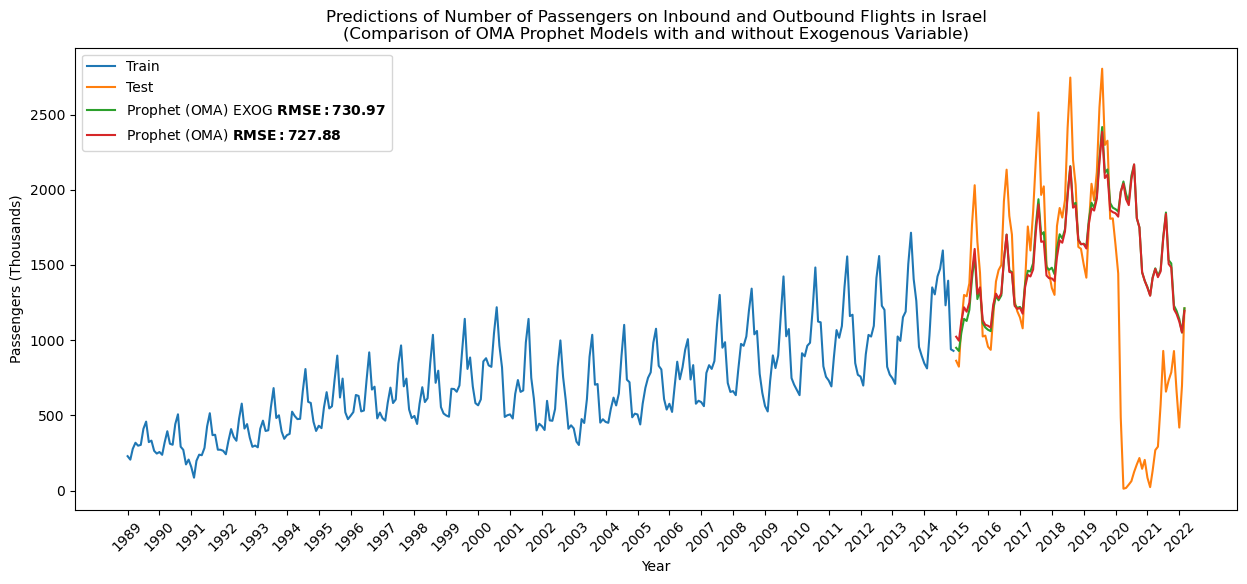

In [59]:
prophet_exog_rmse = calc_rmse(test, prophet_exog_predictions)

saved_models['Prophet (OMA) EXOG']['predictions'] = prophet_exog_predictions
saved_models['Prophet (OMA) EXOG']['RMSE'] = prophet_exog_rmse

plot_predictions(train, test, [prophet_exog_predictions, prophet_predictions],
                    [f"Prophet (OMA) EXOG $\\mathbf{{RMSE: {prophet_exog_rmse:.2f}}}$",
                     f"Prophet (OMA) $\\mathbf{{RMSE: {model_5_with_one_month_ahead_rmse:.2f}}}$"],
                    'Comparison of OMA Prophet Models with and without Exogenous Variable')


The above graph presents the comparison of the OMA Prophet model with and without the exogenous variable in predicting the number of passengers on inbound and outbound flights.

Interestingly, the model lacking the exogenous variable exhibits slightly better performance compared to its counterpart incorporating it. The exact mechanism by which the Prophet model integrates the exogenous variable into its predictions remains unclear to us. However, in this instance, the inclusion of the exogenous variable did not enhance but rather hindered the model's predictive accuracy.

### LSTM

Here, we will only use the OMA version as it is superior.

In [60]:
# Length of sequences
seq_length = 12

# Prepare the training data
combined_train_df = pd.concat([train, train_exr], axis=1)
combined_test_df = pd.concat([test, test_exr], axis=1)
X_train_exog = np.array(combined_train_df)
X_test_exog = np.array(combined_test_df)
X_test_exog = np.concatenate((X_train_exog[-seq_length:], X_test_exog))

scaler_exog = MinMaxScaler(feature_range=(0, 1))
scaled_train_data_exog = scaler_exog.fit_transform(X_train_exog)
scaled_test_data_exog = scaler_exog.transform(X_test_exog)

X_train_exog, y_train_exog = create_sequences(scaled_train_data_exog, seq_length)
X_test_exog, y_test_exog = create_sequences(scaled_test_data_exog, seq_length)

In [61]:
model = create_lstm_model(seq_length, 2)

# OMA LSTM
running_X_train_exog = copy.deepcopy(X_train_exog)
running_y_train_exog = copy.deepcopy(y_train_exog)
running_predictions_exog = []

for test_window, test_point in zip(X_test_exog, y_test_exog):
    model.fit(running_X_train_exog, running_y_train_exog, epochs=100, batch_size=32, verbose=0)
    prediction = model.predict(test_window.reshape(1, seq_length, 2), verbose=0)
    running_X_train_exog = np.concatenate((running_X_train_exog, test_window.reshape(1, seq_length, 2)))
    running_y_train_exog = np.concatenate((running_y_train_exog, test_point.reshape(1, 2)))
    running_predictions_exog.append(scaler.inverse_transform(prediction)[0][0])

In [62]:
lstm_exog_OMA_predictions = pd.Series([])

for i, (test_index, test_point) in enumerate(test.items()):
    lstm_exog_OMA_predictions.at[test_index] = running_predictions_exog[i]

lstm_exog_OMA_relu_predictions = relu(lstm_exog_OMA_predictions)

#### Plot OMA LSTM With Exogenous Variable vs. Without

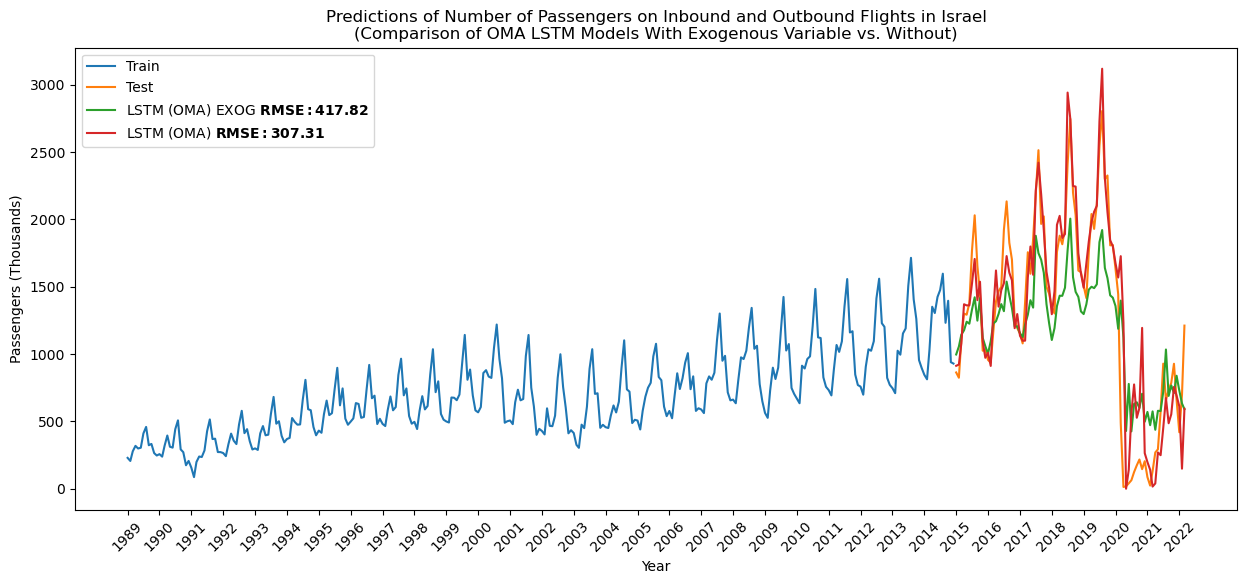

In [63]:
lstm_exog_OMA_rmse = calc_rmse(test, lstm_exog_OMA_predictions)


saved_models['LSTM (OMA) EXOG']['predictions'] = lstm_exog_OMA_relu_predictions
saved_models['LSTM (OMA) EXOG']['RMSE'] = lstm_exog_OMA_rmse

# plot OMA LSTM with exog vs. without
plot_predictions(train, test, [lstm_exog_OMA_relu_predictions, lstm_OMA_relu_predictions],
                    [f"LSTM (OMA) EXOG $\\mathbf{{RMSE: {lstm_exog_OMA_rmse:.2f}}}$",
                     f"LSTM (OMA) $\\mathbf{{RMSE: {lstm_OMA_rmse:.2f}}}$"],
                    title='Comparison of OMA LSTM Models With Exogenous Variable vs. Without')

The above graph presents the comparison of the OMA LSTM model with and without the exogenous variable in predicting the number of passengers on inbound and outbound flights.

Remarkably, the model without the exogenous variable outperforms the one with it. This is surprising, as we initially believed the exogenous variable would enhance the model's predictive accuracy.

### Comparing all OMA Exogenous Models Predictions

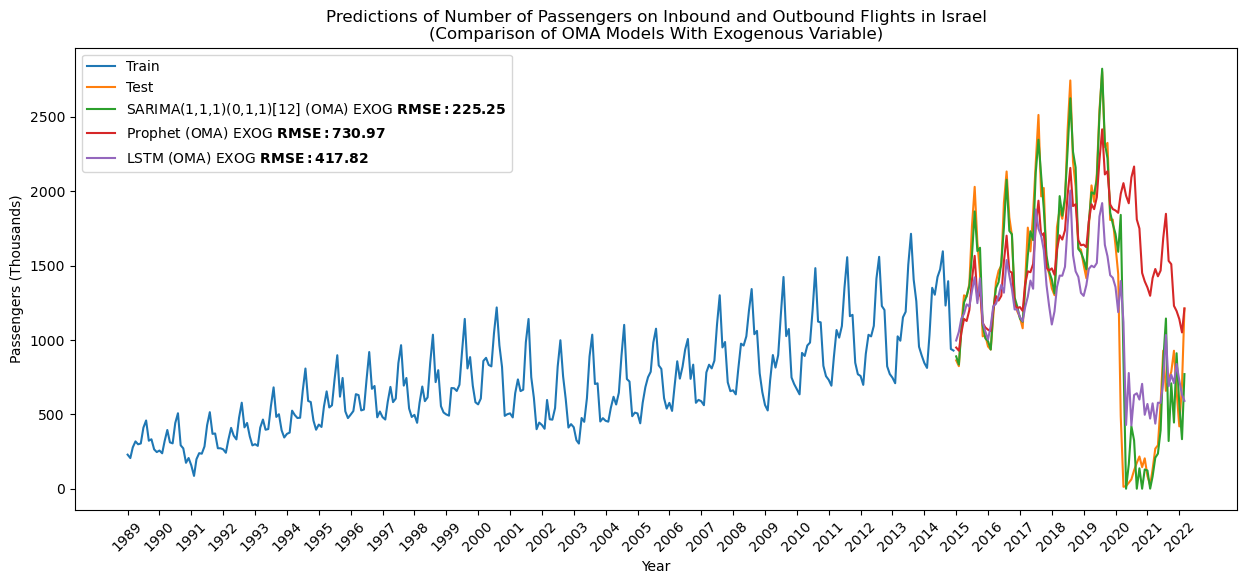

In [64]:
# Extract predictions and labels for all models with EXOG in their keys
exog_models_predictions = [value['predictions'] for key, value in saved_models.items() if 'EXOG' in key]
exog_models_labels = [f"{key} $\\mathbf{{RMSE: {value['RMSE']:.2f}}}$" for key, value in saved_models.items() if 'EXOG' in key]

plot_predictions(train, test, exog_models_predictions, exog_models_labels, 'Comparison of OMA Models With Exogenous Variable')

The above graph presents the comparison of all the OMA models with an exogenous variable in prediction the number of passangers on inbound and outbound flights in Israel.

Again, the $SARIMA$ model outperforms the rest of the models, but here, the LSTM model's performance is significantly worse than the others. This is surprising, as the LSTM model was slightly behind the $SARIMA$ model in the previous part. We believe that the reason for the underperformance of the models with the exogenous variable might be attributed to the fact that the exogenous variable is not correlated with the number of passengers on inbound and outbound and does not help with the predictions.

#### Delving Deeper into the Results

In [65]:
# correlation test between monthly_average_exchange_rate and flights
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(monthly_average_exchange_rate, flights)

print("Pearson correlation coefficient:", correlation)
print("P-value:", p_value)

Pearson correlation coefficient: 0.26113930202628693
P-value: 1.2099199921589485e-07


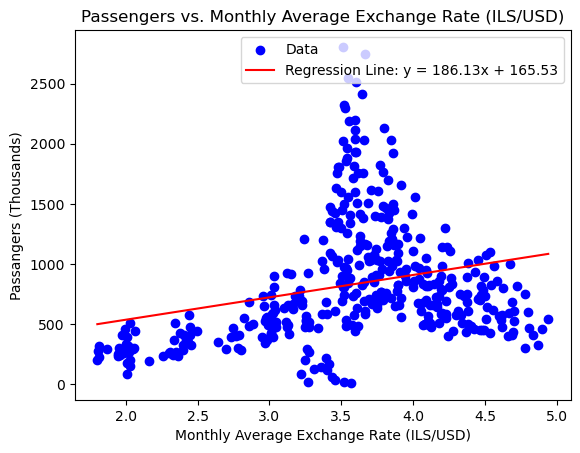

In [66]:
# plot monthly_average_exchange_rate in one axis and flights on the other with regression line

from scipy.stats import linregress

# Assuming you have two Series: monthly_average_exchange_rate and flights

# Create a DataFrame with the two Series
data = pd.DataFrame({'Exchange Rate': monthly_average_exchange_rate, 'Flights': flights})

# Plot the data with regression line
plt.scatter(data['Exchange Rate'], data['Flights'], color='blue', label='Data')

# Calculate the regression line manually
slope, intercept, _, _, _ = linregress(data['Exchange Rate'], data['Flights'])
x = np.array([data['Exchange Rate'].min(), data['Exchange Rate'].max()])
y = slope * x + intercept

# Plot the regression line with equation
plt.plot(x, y, color='red', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

plt.xlabel('Monthly Average Exchange Rate (ILS/USD)')
plt.ylabel('Passangers (Thousands)')
plt.title('Passengers vs. Monthly Average Exchange Rate (ILS/USD)')
plt.legend()
plt.show()

The above graph presents a scatter plot of the number of passengers on inbound and outbound flights to Israel and the monthly average exchage rate between ILS and USD. The regression line and its equation are presented as well.

Based on the results of the Pearson correlation test and the scatter plot provided, we observe a modest positive correlation between our primary variable and the exogenous factor. The correlation coefficient is reported as $0.26$, with a p-value of less than $0.001$, indicating statistical significance. Moreover, the regression slope is determined to be $186.13$, a value that appears relatively moderate when considering the scale of both variables involved.

Thus, we can conclude that the exogenous variable does not significantly correlate with our main variable, and that may be the cause of the underperformance of the models using it.

## Analyzing the Series Before the COVID-19 Pandemic

In this part, we will analyze the series before the COVID-19 pandemic, i.e., until 2019 (including). This is done to emphasize its affect on our results.

In [75]:
PANDEMIC_START_DATE = '2019-12-01'
flights_before_pandemic = flights[:PANDEMIC_START_DATE]
test_before_pandemic = test[:PANDEMIC_START_DATE]

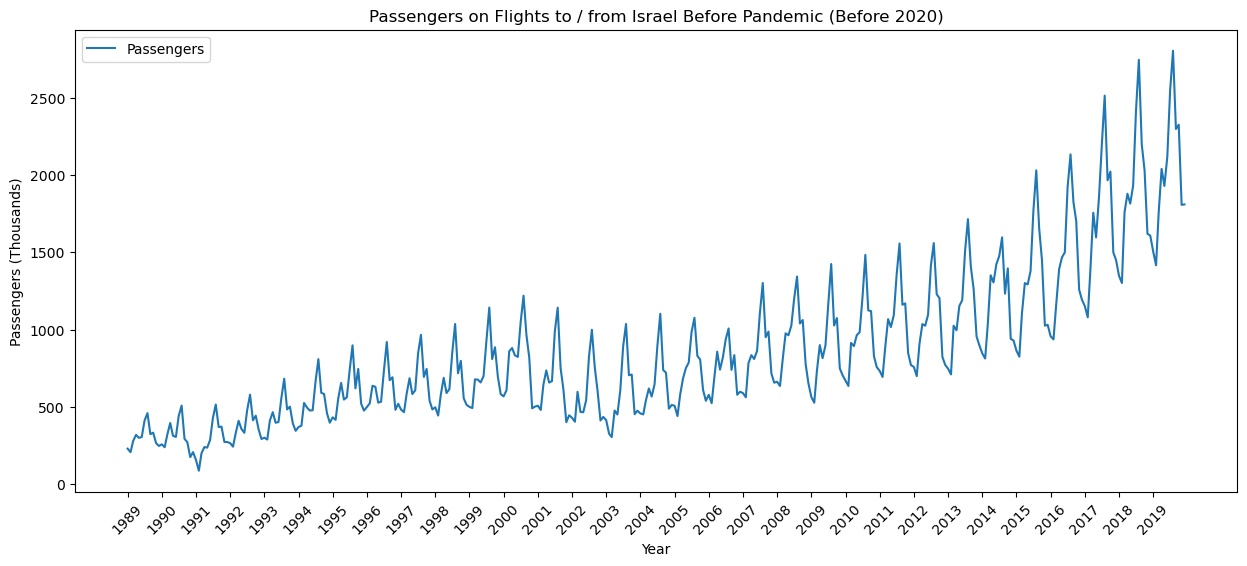

In [76]:
plt.figure(figsize=(15, 6))
plt.plot(flights_before_pandemic, label='Passengers')
plt.title('Passengers on Flights to / from Israel Before Pandemic (Before 2020)') 
plt.xticks(flights_before_pandemic.index[::12], rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Format ticks to show only year
plt.xlabel('Year')
plt.ylabel('Passengers (Thousands)')
plt.legend()

The graph above presents our main data until 2020.

### Without OMA

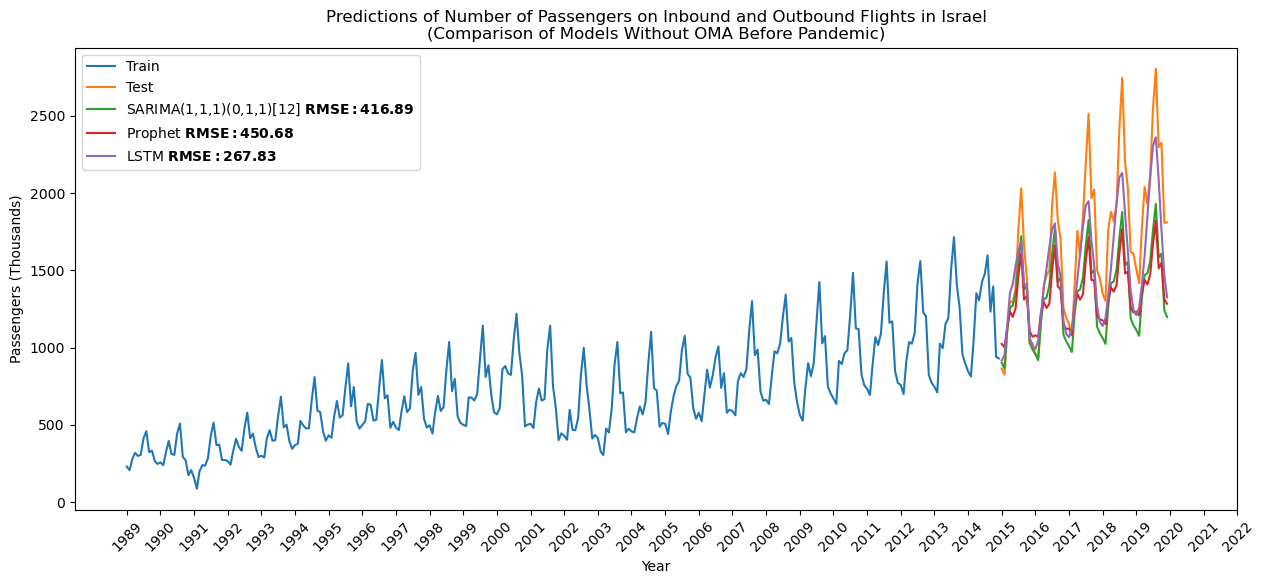

In [86]:
regular_before_pan_predictions = [value['predictions'][:PANDEMIC_START_DATE] for key, value in saved_models.items() if 'OMA' not in key]
regular_before_pan_rmse = [calc_rmse(test_before_pandemic, pred) for pred in regular_before_pan_predictions]
regular_labels = [f"{key} $\\mathbf{{RMSE: {rmse:.2f}}}$" for key, rmse in \
                  zip([model_key for model_key in saved_models.keys() if 'OMA' not in model_key], regular_before_pan_rmse) ]

plot_predictions(train, test_before_pandemic, regular_before_pan_predictions, regular_labels, 'Comparison of Models Without OMA Before Pandemic')

The above graph presents the comparison different models in predicting the number of passengers on inbound and outbound flights in Israel before the pandemic.

As we predicted, the LSTM ourperforms the Prophet and the SARIMA models. Additionally, the models seem to fit the future pretty well! In contrary to what it was with the pandemic.

### With OMA

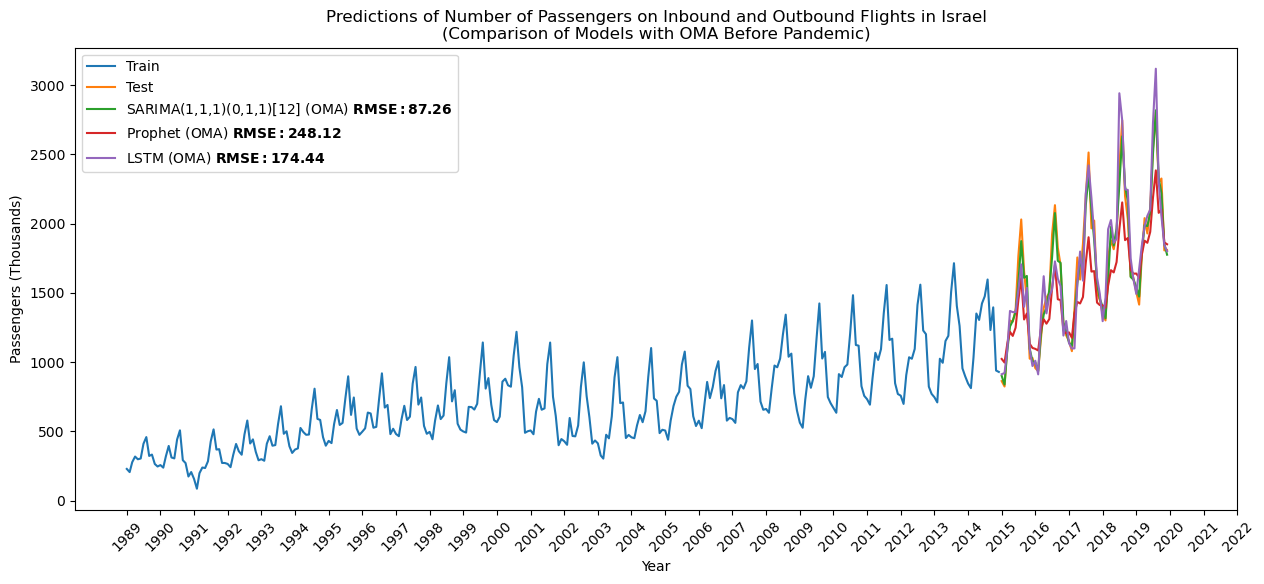

In [87]:
OMA_before_pan_predictions = [value['predictions'][:PANDEMIC_START_DATE] for key, value in saved_models.items() if 'OMA' in key and 'EXOG' not in key]
OMA_before_pan_rmse = [calc_rmse(test_before_pandemic, pred) for pred in OMA_before_pan_predictions]
OMA_labels = [f"{key} $\\mathbf{{RMSE: {rmse:.2f}}}$" for key, rmse in \
              zip([model_key for model_key in saved_models.keys() if 'OMA' in model_key and 'EXOG' not in model_key], OMA_before_pan_rmse)]

plot_predictions(train, test_before_pandemic, OMA_before_pan_predictions, OMA_labels, 'Comparison of Models with OMA Before Pandemic')

The above graph presents the comparison different OMA models in predicting the number of passengers on inbound and outbound flights in Israel before the pandemic.

Surprisingly, the SARIMA models beats the other two by a fair margin, followed by the LSTM model, then Prophet. Again, the models fit the future very well.